In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [15]:
largeDf = pd.read_csv('./finalData.csv')

In [16]:
largeDf

,hadm_id,icustay_id,subject_id,Age,Death,Gender,race_asian,race_black,race_latino,race_white,...,PT,INR,TB,CB,TotalInput,TotalOutput,4hourlyOutput,SOFA,SIRS,GCS
0,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,NaN
1,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,NaN
2,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,NaN
3,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,NaN
4,163557,200003,27513,48.29,1,1,0,0,0,1,...,22.90,2.30,7.000,0.0,0.0,0,0,4,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344795,177406,299994,10718,74.22,0,0,0,0,0,1,...,15.20,1.60,1.400,13348.0,14598.0,1250,0,5,1,15.0
344796,177406,299994,10718,74.22,0,0,0,0,0,1,...,16.40,1.90,1.400,19938.0,22318.0,2380,1130,5,2,15.0
344797,177406,299994,10718,74.22,0,0,0,0,0,1,...,14.10,1.30,1.400,20194.0,23074.0,2880,500,5,0,15.0
344798,177406,299994,10718,74.22,0,0,0,0,0,1,...,13.10,1.20,1.400,20259.0,23139.0,2880,0,5,2,15.0


In [ ]:
def hierarchical_impute_gcs(df, target_col='GCS', patient_id='icustay_id', time_col='bin'):
    """
    Hierarchical imputation for GCS column:
    1. Forward fill (previous time point for same patient)
    2. Backward fill (next time point for same patient) 
    3. Patient mean (average GCS for that patient)
    4. Population mean (overall average GCS)
    5. Normal value (default GCS = 15)
    """

    df_imputed = df.copy()
    
    # Sort by patient and time for proper forward/backward fill
    df_imputed = df_imputed.sort_values([patient_id, time_col])
    
    #  Forward fill within each patient
    df_imputed[f'{target_col}_step1'] = df_imputed.groupby(patient_id)[target_col].fillna(method='ffill')
    step1_filled = df_imputed[f'{target_col}_step1'].notna().sum() - df_imputed[target_col].notna().sum()
    print(f"  - Filled {step1_filled} values with forward fill")
    
    #  Backward fill within each patient
    print(" Backward fill within patients...")
    df_imputed[f'{target_col}_step2'] = df_imputed.groupby(patient_id)[f'{target_col}_step1'].fillna(method='bfill')
    step2_filled = df_imputed[f'{target_col}_step2'].notna().sum() - df_imputed[f'{target_col}_step1'].notna().sum()
    print(f"  - Filled {step2_filled} values with backward fill")
    
    #  Patient mean imputation
    print(" Patient mean imputation...")
    patient_means = df_imputed.groupby(patient_id)[f'{target_col}_step2'].mean()
    df_imputed[f'{target_col}_step3'] = df_imputed[f'{target_col}_step2'].fillna(
        df_imputed[patient_id].map(patient_means)
    )
    step3_filled = df_imputed[f'{target_col}_step3'].notna().sum() - df_imputed[f'{target_col}_step2'].notna().sum()
    print(f"  - Filled {step3_filled} values with patient means")
    
    #  Population mean imputation
    print(" Population mean imputation...")
    population_mean = df_imputed[f'{target_col}_step3'].mean()
    df_imputed[f'{target_col}_step4'] = df_imputed[f'{target_col}_step3'].fillna(population_mean)
    step4_filled = df_imputed[f'{target_col}_step4'].notna().sum() - df_imputed[f'{target_col}_step3'].notna().sum()
    print(f"  - Filled {step4_filled} values with population mean ({population_mean:.2f})")
    
    #  Normal value imputation
    print(" Normal value imputation...")
    normal_gcs = 15
    df_imputed[f'{target_col}'] = df_imputed[f'{target_col}_step4'].fillna(normal_gcs)
    step5_filled = df_imputed[f'{target_col}'].notna().sum() - df_imputed[f'{target_col}_step4'].notna().sum()
    print(f"  - Filled {step5_filled} values with normal GCS ({normal_gcs})")
    
    # Clean up intermediate columns
    cols_to_drop = [f'{target_col}_step{i}' for i in range(1, 5)]
    df_imputed = df_imputed.drop(columns=cols_to_drop)
    
    return df_imputed

# Apply hierarchical imputation to GCS
largeDf_imputed = hierarchical_impute_gcs(largeDf)


/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_81255/270445088.py:17: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_imputed[f'{target_col}_step1'] = df_imputed.groupby(patient_id)[target_col].fillna(method='ffill')
/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_81255/270445088.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed[f'{target_col}_step1'] = df_imputed.groupby(patient_id)[target_col].fillna(method='ffill')


  - Filled 62429 values with forward fill
 Backward fill within patients...


/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_81255/270445088.py:23: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_imputed[f'{target_col}_step2'] = df_imputed.groupby(patient_id)[f'{target_col}_step1'].fillna(method='bfill')
/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_81255/270445088.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed[f'{target_col}_step2'] = df_imputed.groupby(patient_id)[f'{target_col}_step1'].fillna(method='bfill')


  - Filled 77321 values with backward fill
 Patient mean imputation...
  - Filled 0 values with patient means
 Population mean imputation...
  - Filled 2620 values with population mean (14.44)
 Normal value imputation...
  - Filled 0 values with normal GCS (15)


In [18]:
largeDf_imputed

,hadm_id,icustay_id,subject_id,Age,Death,Gender,race_asian,race_black,race_latino,race_white,...,PT,INR,TB,CB,TotalInput,TotalOutput,4hourlyOutput,SOFA,SIRS,GCS
0,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,15.0
1,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,15.0
2,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,15.0
3,163557,200003,27513,48.29,1,1,0,0,0,1,...,16.58,1.56,6.775,0.0,0.0,0,0,4,2,15.0
4,163557,200003,27513,48.29,1,1,0,0,0,1,...,22.90,2.30,7.000,0.0,0.0,0,0,4,3,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344795,177406,299994,10718,74.22,0,0,0,0,0,1,...,15.20,1.60,1.400,13348.0,14598.0,1250,0,5,1,15.0
344796,177406,299994,10718,74.22,0,0,0,0,0,1,...,16.40,1.90,1.400,19938.0,22318.0,2380,1130,5,2,15.0
344797,177406,299994,10718,74.22,0,0,0,0,0,1,...,14.10,1.30,1.400,20194.0,23074.0,2880,500,5,0,15.0
344798,177406,299994,10718,74.22,0,0,0,0,0,1,...,13.10,1.20,1.400,20259.0,23139.0,2880,0,5,2,15.0


In [19]:
largeDf_imputed.to_csv('./finalData.csv')

In [20]:
df = largeDf_imputed
df.describe()

,hadm_id,icustay_id,subject_id,Age,Death,Gender,race_asian,race_black,race_latino,race_white,...,PT,INR,TB,CB,TotalInput,TotalOutput,4hourlyOutput,SOFA,SIRS,GCS
count,344800.000000,344800.000000,344800.000000,344800.00000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,...,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000,344800.000000
mean,150141.273898,250081.742517,45337.503480,76.41503,0.444200,0.577436,0.024826,0.098898,0.035673,0.732309,...,16.056319,1.496338,5.661311,2498.626045,4984.105825,2485.479782,260.695737,4.183016,1.464985,14.437431
std,28969.638890,28856.894399,29993.143077,54.78675,0.496877,0.493968,0.155595,0.298525,0.185473,0.442756,...,6.458506,0.842860,6.529222,5675.732491,6177.929779,3777.450618,561.526631,2.225473,0.936186,1.680582
min,100003.000000,200003.000000,4.000000,18.02000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,0.100000,0.100000,-252275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,125123.250000,225012.000000,18676.000000,54.78000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.200000,1.150000,0.550000,0.000000,135.000000,0.000000,0.000000,3.000000,1.000000,15.000000
50%,150255.500000,250247.000000,44029.500000,66.91000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,14.400000,1.300000,1.733333,555.000000,3027.000000,1570.000000,120.000000,4.000000,1.000000,15.000000
75%,175287.500000,274872.500000,71577.750000,78.28000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,16.600000,1.550000,12.000000,4246.000000,7526.000000,3693.250000,350.000000,5.000000,2.000000,15.000000
max,199995.000000,299994.000000,99995.000000,310.17000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,150.000000,48.200000,346.200000,318257.500000,321571.496194,266435.000000,50680.000000,22.000000,4.000000,15.000000


In [21]:
df.columns

Index(['hadm_id', 'icustay_id', 'subject_id', 'Age', 'Death', 'Gender',
       'race_asian', 'race_black', 'race_latino', 'race_white', 'race_other',
       '90D_Mortality', 'Weight', 'bin', 'PH', 'PaO2', 'PaCO2', 'PaO2/FiO2',
       'ArterialBE', 'HCO3', 'FiO2', 'HGB', 'Chloride', 'Calcium', 'Magnesium',
       'SGPT', 'SGOT', 'Temperature', 'HR', 'RR', 'SBP', 'DBP', 'MBP',
       'ShockIndex', 'SpO2', 'AL', 'BUN', 'Creatinine', 'Platelet', 'WBC',
       'Potassium', 'Sodium', 'Glucose', 'PTT', 'PT', 'INR', 'TB', 'CB',
       'TotalInput', 'TotalOutput', '4hourlyOutput', 'SOFA', 'SIRS', 'GCS'],
      dtype='object')

In [ ]:
cols = ['hadm_id', 'icustay_id', 'subject_id', '90D_Mortality']
X = df.drop(columns= cols + ['Death'])
y = df['Death'].values

In [30]:
feature_names = X.columns

In [44]:
len(feature_names)

49

In [24]:
rf = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    random_state=33
)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=33)

#### Out-of-Bag (OOB) Permutation Importance

In [ ]:
def oob_permutation_importance_exact(rf, X, y):
    n_features = X.shape[1]
    importances = np.zeros(n_features)

    for tree_idx, tree in enumerate(tqdm(rf.estimators_, desc="Calculating OOB importance")):
        oob_mask = ~rf.estimators_samples_[tree_idx]
        if not np.any(oob_mask):
            continue
        
        X_oob = X[oob_mask]
        y_oob = y[oob_mask]

        # Baseline accuracy for this tree's OOB samples
        baseline_preds = tree.predict(X_oob)
        baseline_acc = np.mean(baseline_preds == y_oob)

        # Permute each feature in OOB samples
        for i in range(n_features):
            X_perm = X_oob.copy()
            X_perm[:, i] = np.random.permutation(X_perm[:, i])
            perm_preds = tree.predict(X_perm)
            perm_acc = np.mean(perm_preds == y_oob)

            importances[i] += (baseline_acc - perm_acc)

    # Average over all trees
    importances /= len(rf.estimators_)
    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

X_np = X.values
feature_importances = oob_permutation_importance_exact(rf, X_np, y)

Calculating OOB importance: 100%|██████████| 500/500 [46:17<00:00,  5.55s/it]


#### Sequential Backward Search

In [35]:
features = list(feature_importances.index)
best_acc = 0
best_features = features.copy()

for _ in tqdm(range(len(features) - 37), desc="Sequential Backward Search"):
    acc = cross_val_score(
        RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=33),
        X[features],
        y,
        cv=5
    ).mean()

    if acc > best_acc:
        best_acc = acc
        best_features = features.copy()

    # Drop the least important remaining feature
    least_important = feature_importances[features].idxmin()
    features.remove(least_important)

print("\nBest Accuracy:", best_acc)
print("Selected Features ({} total):".format(len(best_features)))
print(best_features)

Sequential Backward Search: 100%|██████████| 12/12 [46:59<00:00, 234.97s/it]


Best Accuracy: 0.7206177494199535
Selected Features (45 total):
['Age', 'BUN', 'Weight', 'Creatinine', 'INR', 'PaO2', 'PT', 'Chloride', 'Platelet', 'Sodium', 'PTT', 'TotalInput', 'SOFA', 'DBP', 'AL', 'Temperature', 'TB', 'CB', 'HGB', 'ArterialBE', 'WBC', 'PaCO2', 'Potassium', 'FiO2', 'RR', 'PaO2/FiO2', 'Glucose', 'PH', 'ShockIndex', 'Calcium', 'HR', 'MBP', 'SBP', 'TotalOutput', 'SGPT', 'SpO2', 'SGOT', '4hourlyOutput', 'Magnesium', 'Gender', 'bin', 'race_white', 'SIRS', 'GCS', 'race_black']


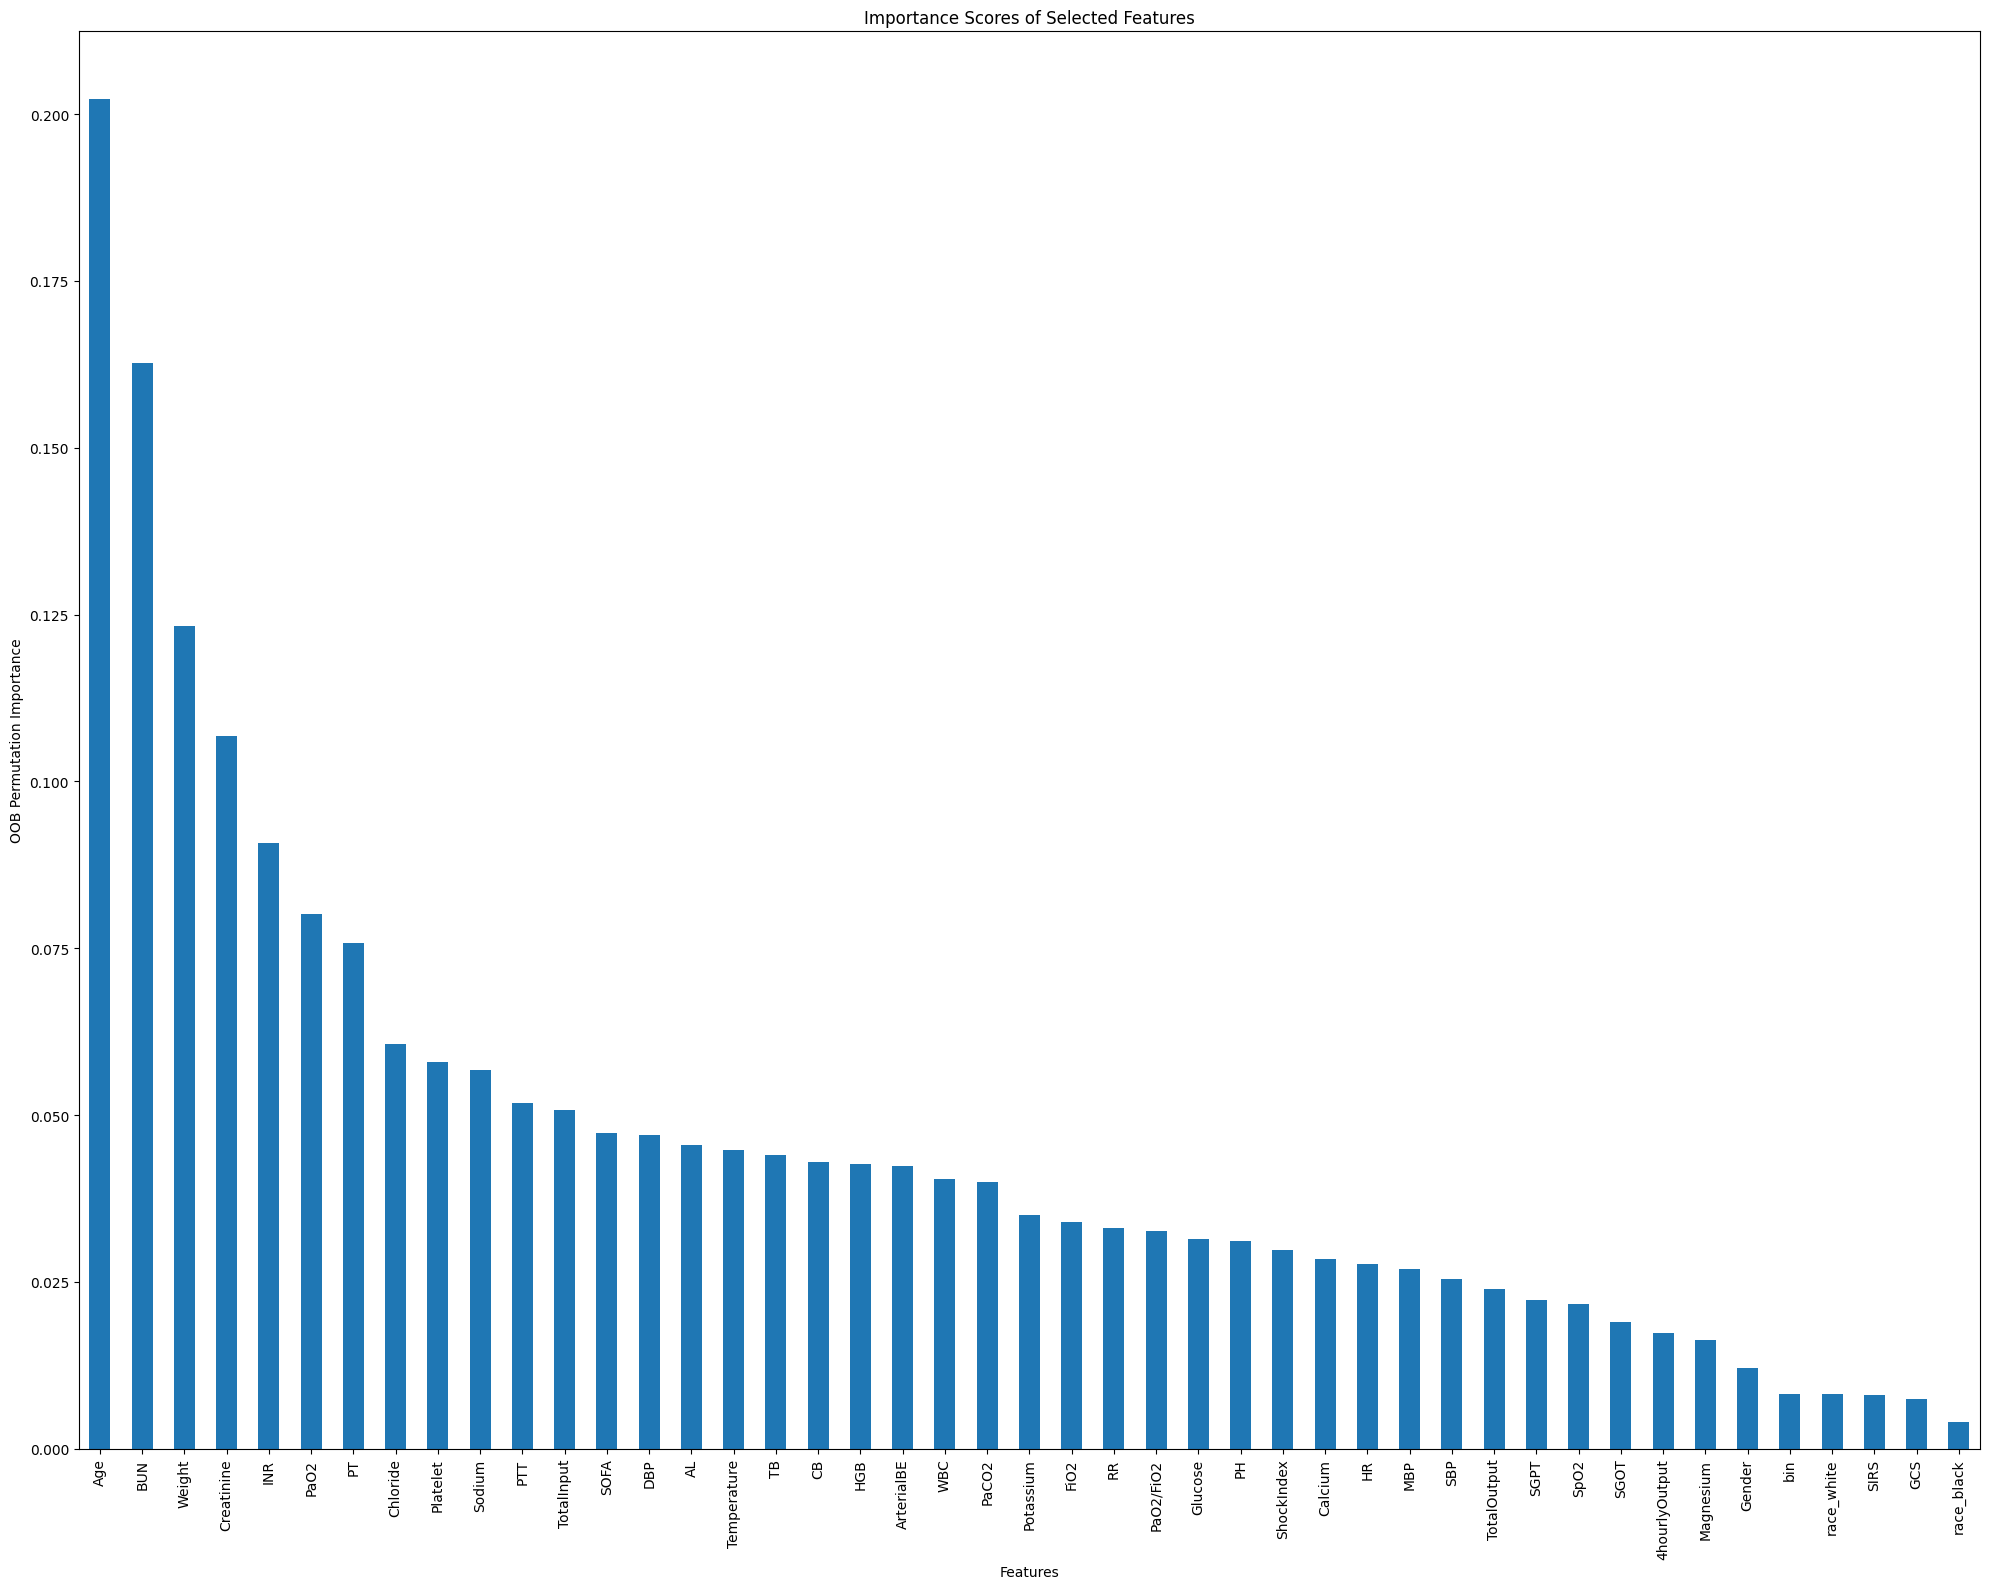

In [38]:
best_feature_importances = feature_importances[best_features]

plt.figure(figsize=(20, 16)) 
best_feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('OOB Permutation Importance')
plt.title('Importance Scores of Selected Features')
plt.tight_layout()
plt.show()

In [49]:
len(feature_names)

49

In [48]:
best_features = ['Age', 'BUN', 'Weight', 'Creatinine', 'INR', 'PaO2', 'PT', 'Chloride', 'Platelet', 'Sodium', 'PTT', 'TotalInput', 'SOFA', 'DBP', 'AL', 'Temperature', 'TB', 'CB', 'HGB', 'ArterialBE', 'WBC', 'PaCO2', 'Potassium', 'FiO2', 'RR', 'PaO2/FiO2', 'Glucose', 'PH', 'ShockIndex', 'Calcium', 'HR', 'MBP', 'SBP', 'TotalOutput', 'SGPT', 'SpO2', 'SGOT', '4hourlyOutput', 'Magnesium', 'Gender', 'bin', 'race_white', 'SIRS', 'GCS', 'race_black']
len(best_features)

45

In [50]:
removed_features = [feature for feature in feature_names if feature not in best_features]
removed_features

['race_asian', 'race_latino', 'race_other', 'HCO3']

### So, we drop ethnicity and bicarbonate.